In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch
DEVICE = torch.device('cpu')

NAME = 'ladle_furnace_inference'

# **Ladle furnace benchmark: inference**

In this example, we'll be analysing different **fill-level inference methods** for the task described in our initial [TomOpt paper](https://arxiv.org/abs/2309.14027). We aim at demonstrating the **capability** of the designed methods **to infer the fill level of a furnace ladle containing melted steel**. These methods should work well with varied detector configurations in order to yield meaningful optimisation results.

Additional analyses and tests can be found in the 6th chapter of this [thesis](https://hdl.handle.net/10902/31109).

## **Building scenarios with different detector configurations**

We'll begin by defining the **number of simulations** we want to produce, their individual **data taking time**, and the considered **flux of muons**.

In [2]:
Simulations = 100 # number of simulations
Time = 5 # muography measurement time of a single simulation [min]
Flux = 6845 # considered flux of muons [muons/(min*m^2)]

Then, we will continue defining 4 scenarios with different detector configurations. Each scenario corresponds to a **volume**, consisting of the configured **detectors** and a **passive volume**. 

In [3]:
from tomopt.volume import Volume
from tomopt.benchmarks.ladle_furnace import get_detector

In [4]:
# Detection panel span [m]
PanelSpan = 0.7
# PanelSpan = 0.9

# muon hit detection resolution [m]
Resolution = 0.00001 # 0,01 mm (really high resolution)

PanelZ = [1.80, 1.65, 1.50, 0.30, 0.15, 0.00] # Big gap

volume_BigGapHighRes = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e5, panelZpositions=PanelZ), budget=6)
volume_BigGapHighRes

# muon hit detection resolution [m]
Resolution = 0.001 # 1 mm (common muography detector)

volume_BigGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_BigGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.25, 0.20] # Small gap

volume_SmallGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_SmallGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.15, 0.00] # Not centred

volume_NotCentred = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_NotCentred


Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

We can visualise the layout of this in 3D.

#### a) Big gap detection panels

<IPython.core.display.Javascript object>


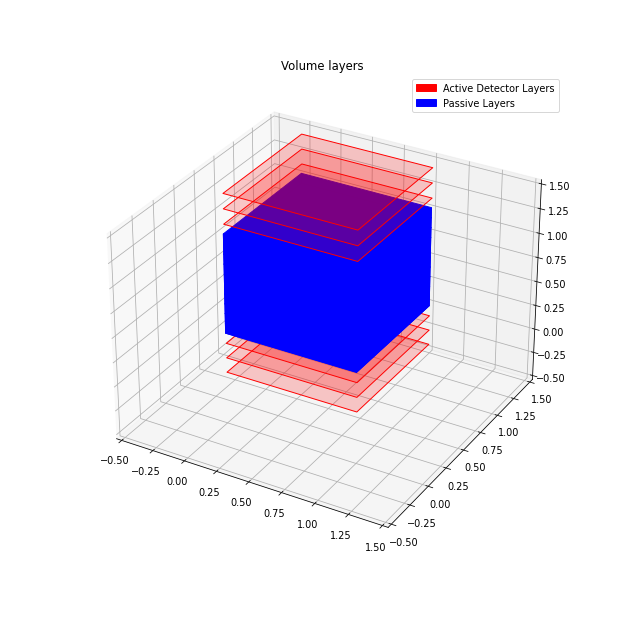

In [19]:
%matplotlib notebook
volume_BigGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

#### b) Small gap detection panels

<IPython.core.display.Javascript object>


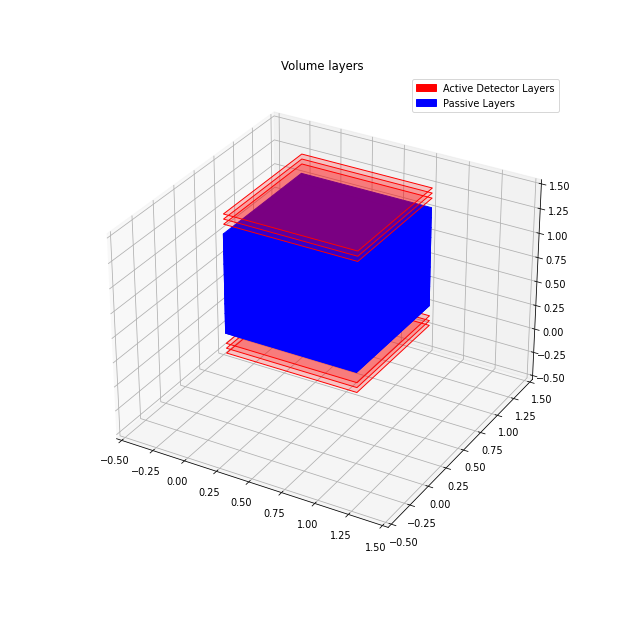

In [20]:
%matplotlib notebook
volume_SmallGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

#### c) Not centred detection panels

<IPython.core.display.Javascript object>


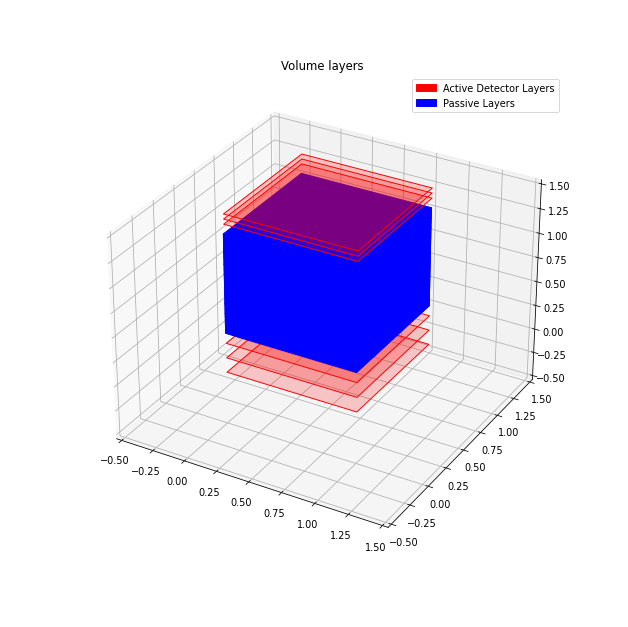

In [21]:
%matplotlib notebook
volume_NotCentred.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

In [8]:
%matplotlib inline

## **Passive volume generation**

Now we'll need to define how to **generate** example **passive volumes**. The furnace ladle is made of several elements:

 - **Ladle**: a $1\times1\times1 \:[\text{m}^3]$ bucket made of solid steel.

 - **Liquid steel**: The ladle is filled with a **random amount** of liquid steel.

 - **Slag**: Above the liquid steel is a **layer** of **slag**, with a lower density that liquid steel.

 - **Air**: The rest of the ladle is filled with air.


`LadleFurnacePassiveGenerator` class will create layouts based on varying fill-heights of a furnace ladle, with varying levels of slag.

In [9]:
from tomopt.benchmarks.ladle_furnace import LadleFurnacePassiveGenerator

In [10]:
# Choose volume
volume=volume_BigGapHighRes
# volume=volume_BigGap
# volume=volume_SmallGap
# volume=volume_NotCentred

print(volume)
# volume.get_detectors(), volume.get_passives()

passive_gen = LadleFurnacePassiveGenerator(volume)

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.8000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

We'll generate 10 volumes at a every fill-height. The 10cm of slag will be present for ever volume.

In [11]:
N_PASSIVES_PER_H = 10
HEIGHTS = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

from tomopt.optimisation import PassiveYielder

trn_passives = PassiveYielder([passive_gen._generate(fixed_mat_z=h, fixed_slag_z=h+0.1)
                               for _ in range(N_PASSIVES_PER_H) for h in HEIGHTS])

This is the amount of passive volumes generated.

In [12]:
len(trn_passives)

80

Let's visualise one of these volume layouts by repurposing one of the visualisers in TomOpt

In [13]:
SelectedVolume = 10
f,t = trn_passives.passives[SelectedVolume]
volume.load_rad_length(f, t)

In [14]:
# Get X0 of all voxels
x0 = volume.get_rad_cube()
x0.shape, x0

(torch.Size([10, 10, 10]),
 tensor([[[1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-0

In [15]:
from tomopt.plotting import plot_true_x0, plot_pred_true_x0
from tomopt.utils import x0targs_to_classtargs
from tomopt.core import X0

In [16]:
import numpy as np

In [17]:
type(1/np.sqrt(volume.get_rad_cube()))

torch.Tensor

In [28]:
volume.get_rad_cube()[:,4,4]*100

tensor([1.7820e+00, 1.9910e+00, 1.9910e+00, 1.9910e+00, 8.2110e+00, 3.0390e+04,
        3.0390e+04, 3.0390e+04, 3.0390e+04, 3.0390e+04])

true


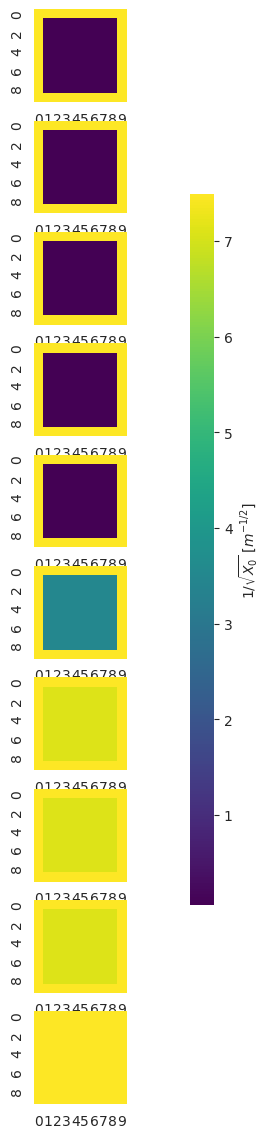

In [32]:
%matplotlib inline
# plot_pred_true_x0(pred=1/np.sqrt(volume.get_rad_cube()), true=1/np.sqrt(volume.get_rad_cube()), ColorBarLabel=r'$1/\sqrt{X0} \ [cm^{-1/2}]$')
plot_pred_true_x0(true=1/np.sqrt(volume.get_rad_cube()), ColorBarLabel=r'$1/\sqrt{X_0} \ [m^{-1/2}]$')


In the plot of the cell above the layers of the ladle can be observed, coloured depending on the X0 of the voxel material:

 - Yellow = **ladle** (steel) 
 - Light green = **liquid steel** 
 - Dark green = **Slag** 
 - Blue = **Air**

The inverse of the square root of X0 has been plotted, a value which is approximately linear to the material density. We can see that the metals have very similar X0, but they are slightly distinguishable from the slag.

## **Muon generation and propagation**


In [33]:
from tomopt.muon import MuonGenerator2016 as MuonGenerator

In [34]:
# gen = MuonGenerator.from_volume(volume, fixed_mom=5)
gen = MuonGenerator.from_volume(volume, fixed_mom=None)
gen

Muon generator: x,y range: (-0.40192377427276926, 1.4019237742727693), (-0.40192377427276926, 1.4019237742727693). Energy sampled from 0.5087855416698359-491.5127197474533 GeV.

In [35]:
from tomopt.muon import MuonBatch

In [36]:
muons = MuonBatch(gen(2000), init_z=1.8)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(1.3097), muons.y[0]=tensor(-0.0162), muons.z[0]=tensor(1.8000), muons.theta[0]=tensor(0.5589)'

In [37]:
volume(mu=muons)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.1839), muons.y[0]=tensor(-0.0083), muons.z[0]=tensor(0.), muons.theta[0]=tensor(0.5589)'

In [38]:
hits = muons.get_hits()
hits

{'above': {'reco_xyz': tensor([[[ 1.3097, -0.0162,  1.8000],
           [ 1.2159, -0.0155,  1.6500],
           [ 1.1220, -0.0149,  1.5000]],
  
          [[ 1.1046,  0.3298,  1.8000],
           [ 1.0825,  0.3927,  1.6500],
           [ 1.0603,  0.4557,  1.5000]],
  
          [[ 0.6394,  1.2671,  1.8000],
           [ 0.6482,  1.2375,  1.6500],
           [ 0.6569,  1.2093,  1.5000]],
  
          ...,
  
          [[-0.0520,  0.1986,  1.8000],
           [-0.0887,  0.2208,  1.6500],
           [-0.1252,  0.2430,  1.5000]],
  
          [[ 0.7862,  0.0947,  1.8000],
           [ 0.6699,  0.2759,  1.6500],
           [ 0.5536,  0.4570,  1.5000]],
  
          [[ 0.2743,  0.0268,  1.8000],
           [ 0.3650,  0.1257,  1.6500],
           [ 0.4557,  0.2246,  1.5000]]], grad_fn=<StackBackward0>),
  'gen_xyz': tensor([[[ 1.3097, -0.0162,  1.8000],
           [ 1.2159, -0.0155,  1.6500],
           [ 1.1221, -0.0149,  1.5000]],
  
          [[ 1.1046,  0.3298,  1.8000],
           [ 1.08

In [39]:
hits['above']['reco_xyz'].shape  # (muons, detector layer, xy)

torch.Size([2000, 3, 3])

In [40]:
from tomopt.inference import ScatterBatch

In [41]:
%%time
sb = ScatterBatch(mu=muons, volume=volume)

CPU times: user 204 ms, sys: 8.31 ms, total: 212 ms
Wall time: 405 ms


In [42]:
%%time
sb.poca_xyz, sb.poca_xyz_unc

CPU times: user 21.3 s, sys: 12.3 s, total: 33.6 s
Wall time: 20.4 s


(tensor([[ 0.8923,  0.9242,  0.3759],
         [ 0.7213,  0.9975,  0.3996],
         [ 0.3555,  0.1591,  0.6509],
         ...,
         [-0.3381,  0.3719,  0.6280],
         [ 0.2311,  0.9590,  1.0849],
         [ 0.9254,  0.7366,  0.7226]], grad_fn=<AddBackward0>),
 tensor([[1.3171e-04, 1.8733e-04, 3.4892e-04],
         [3.8669e-04, 1.2706e-03, 6.0760e-03],
         [5.8522e-05, 2.5026e-04, 2.2209e-04],
         ...,
         [1.6330e-01, 9.8902e-02, 6.6930e-01],
         [5.7628e-03, 8.9482e-03, 7.3774e-03],
         [3.9958e-04, 3.8289e-04, 6.1158e-04]], grad_fn=<SqrtBackward0>))

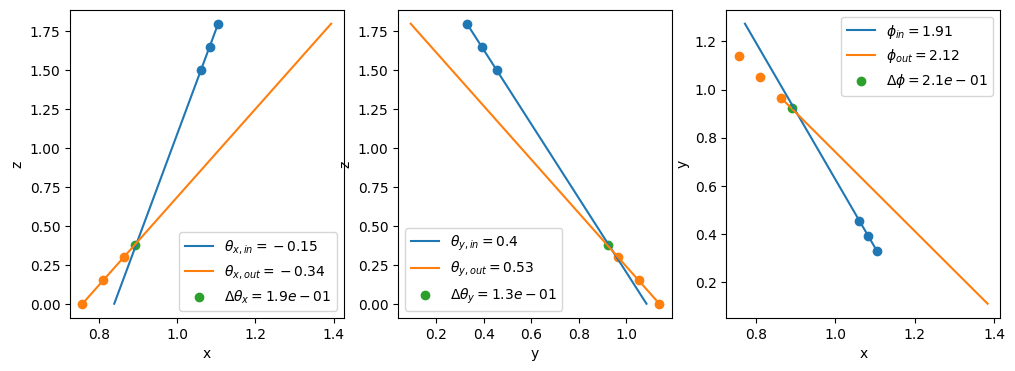

In [43]:
sb.plot_scatter(idx=0)

## **Inference example**

In [44]:
import matplotlib.pyplot as plt

In [45]:
1/np.sqrt(volume.get_rad_cube()[:,4,4])

tensor([7.4911, 7.0870, 7.0870, 7.0870, 3.4898, 0.0574, 0.0574, 0.0574, 0.0574,
        0.0574])

0.30000000000000004

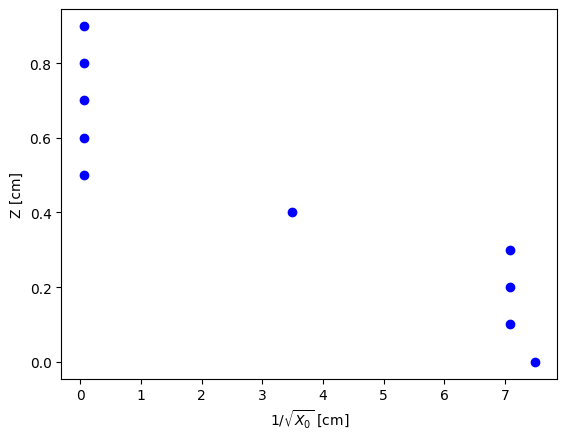

In [46]:
# Get true steel level
plt.plot(1/np.sqrt(volume.get_rad_cube()[:,4,4]), np.arange(0, len(np.sqrt(volume.get_rad_cube()[:,4,4])))*0.1, "bo")
plt.xlabel(r"$1/\sqrt{X_0}$ [cm]")
plt.ylabel("Z [cm]")

PassiveLayerThickness = 0.1
SteelLevel_True = np.unique(volume.get_rad_cube()[:,4,4]==volume.get_rad_cube()[1,4,4], return_counts=True)[1][1]*PassiveLayerThickness
SteelLevel_True

In [47]:
PocaZ = sb.poca_xyz[:, 2].detach().numpy()
FurnaceBottom = 0.5
SteelLevel_Pred = (np.mean(PocaZ)-FurnaceBottom)*2
print("Actual steel level [m]: " + str(round(SteelLevel_True, 4)))
print("Predicted steel level [m]: " + str(round(SteelLevel_Pred, 4)))
# np.mean(PocaZ)

Actual steel level [m]: 0.3
Predicted steel level [m]: 0.366


In [48]:
sb.poca_xyz.detach().cpu().numpy()[:, 0].shape

(1328,)

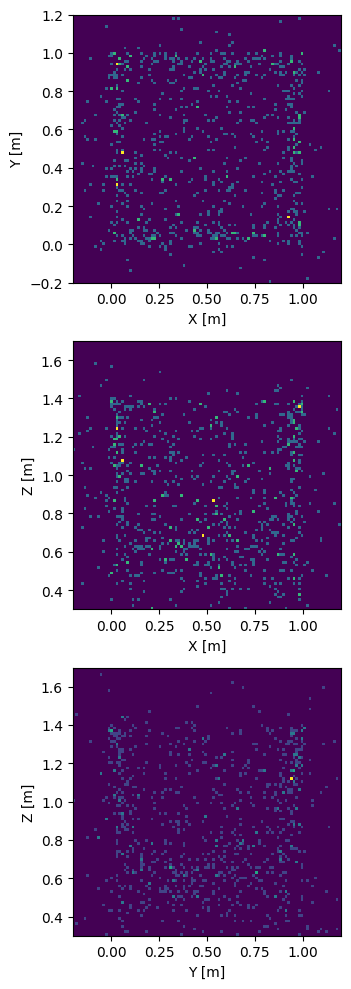

In [49]:
sb.plot_poca_batch(Zlims=[0.5-0.2, 1.5+0.2])

In [50]:
PocaZ

array([0.3758521, 0.3995768, 0.6509202, ..., 0.6279886, 1.0848839,
       0.7225929], dtype=float32)

#### All POCA

Actual steel level [m]: 0.3
Predicted steel level [m]: 0.266


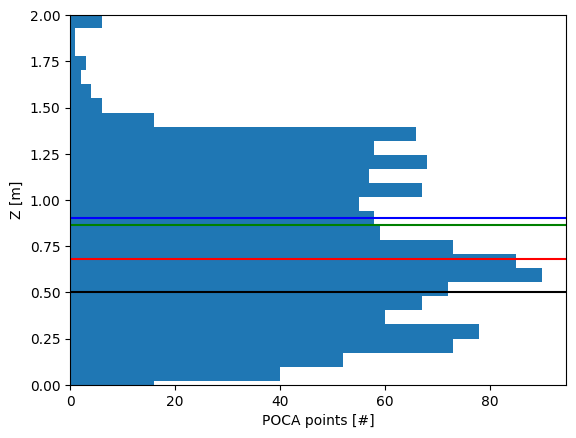

In [51]:
%matplotlib inline

FurnaceBottom = 0.5
BottomWallThickness = 0.1

PocaZ = sb.poca_xyz[:, 2].detach().numpy()

SteelLevel_Pred = (np.mean(PocaZ)-(FurnaceBottom))*2-BottomWallThickness
print("Actual steel level [m]: " + str(round(SteelLevel_True, 4)))
print("Predicted steel level [m]: " + str(round(SteelLevel_Pred, 4)))
# np.mean(PocaZ)

plt.axhline(y=np.mean(PocaZ), color='r', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_Pred, color='g', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_True, color='b', linestyle='-')
plt.axhline(y=FurnaceBottom, color='k', linestyle='-')
# plt.axhline(y=FurnaceBottom+0.1, color='k', linestyle='-')

plt.hist(PocaZ, bins=200, orientation="horizontal")
plt.ylim(0,2)

plt.xlabel("POCA points [#]")
plt.ylabel("Z [m]")

plt.show()


#### POCA within furnace XY walls

In [66]:
Poca_x = sb.poca_xyz[:, 0].detach().numpy()
Poca_y = sb.poca_xyz[:, 1].detach().numpy()

f_x = (Poca_x > 0.1) & (Poca_x < 0.9)
f_y = (Poca_y > 0.1) & (Poca_y < 0.9)


Actual steel level [m]: 0.3
Predicted steel level [m]: 0.2875


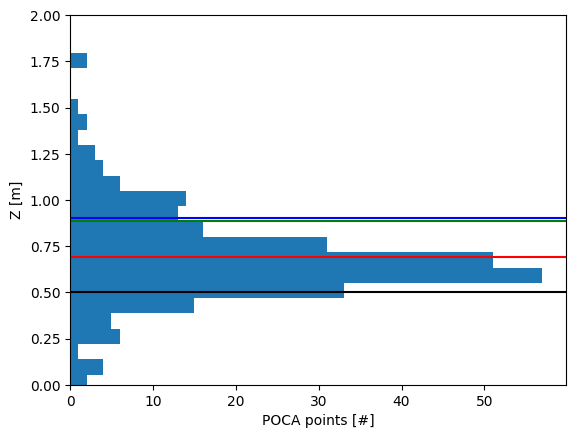

In [68]:
%matplotlib inline

Poca_z = sb.poca_xyz[:, 2].detach().numpy()
Poca_x = sb.poca_xyz[:, 0].detach().numpy()
Poca_y = sb.poca_xyz[:, 1].detach().numpy()

# Select POCA points within XY furnace walls
f_x = (Poca_x > 0.1) & (Poca_x < 0.9)
f_y = (Poca_y > 0.1) & (Poca_y < 0.9)
f = f_x & f_y

Poca_z = Poca_z[f]

SteelLevel_Pred = (np.mean(Poca_z)-(FurnaceBottom))*2-BottomWallThickness
print("Actual steel level [m]: " + str(round(SteelLevel_True, 4)))
print("Predicted steel level [m]: " + str(round(SteelLevel_Pred, 4)))
# np.mean(PocaZ)

plt.axhline(y=np.mean(Poca_z), color='r', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_Pred, color='g', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_True, color='b', linestyle='-')
plt.axhline(y=FurnaceBottom, color='k', linestyle='-')
# plt.axhline(y=FurnaceBottom+0.1, color='k', linestyle='-')

plt.hist(Poca_z, bins=50, orientation="horizontal")
plt.ylim(0,2)

plt.xlabel("POCA points [#]")
plt.ylabel("Z [m]")

plt.show()

# Run multiple simulations and get POCA mean, as well as true steel level

In [69]:
len(trn_passives)

80

### Generation

In [70]:
GeneratedMuons = 10000
muons = MuonBatch(gen(10000), init_z=1.8)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.8016), muons.y[0]=tensor(0.7879), muons.z[0]=tensor(1.8000), muons.theta[0]=tensor(0.6689)'

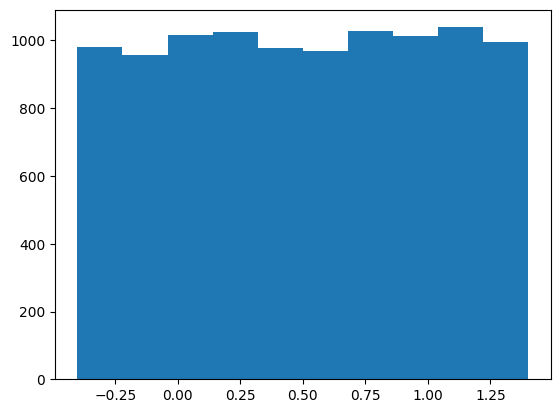

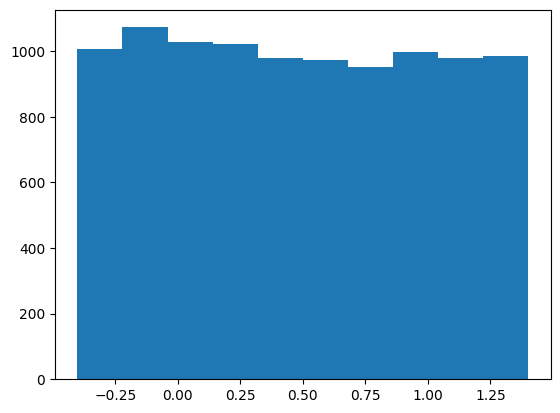

2.25

In [71]:
plt.hist(muons.x)
plt.show()

plt.hist(muons.y)
plt.show()

# Generation surface of 1.5x1.5 m²

1.5*1.5

In [72]:
import sys

def ProgBar(percent, bar_length = 30):  # bar_length should be less than 100
    sys.stdout.write('\r')
    sys.stdout.write("Completed: [{:{}}] {:>3}%"
                     .format('='*int(percent/(100.0/bar_length)),
                             bar_length, int(percent)))
    sys.stdout.flush()

In [73]:
import time
import sys

total = 1007  # total number to reach
bar_length = 30  # should be less than 100
for i in range(total+1):
    percent = 100.0*i/total
    sys.stdout.write('\r')
    sys.stdout.write("Completed: [{:{}}] {:>3}%"
                     .format('='*int(percent/(100.0/bar_length)),
                             bar_length, int(percent)))
    sys.stdout.flush()
    time.sleep(0.002)

Completed: [==============================] 100%

In [74]:
TrueSteelLevels = np.zeros(len(trn_passives.passives))
TrueSteelLevels[:] = np.nan

Poca_z_means = np.zeros(len(trn_passives.passives))
Poca_z_means[:] = np.nan

for i in range(0, len(trn_passives.passives)):
    # print(i)
    
    ProgBar(percent=100.0*i/len(trn_passives.passives))
    
    SelectedVolume = i
    f,t = trn_passives.passives[SelectedVolume]
    volume.load_rad_length(f, t)
    
    # plot_pred_true_x0(1/np.sqrt(volume.get_rad_cube()), 1/np.sqrt(volume.get_rad_cube()))
    
    GeneratedMuons = 1000
    muons = MuonBatch(gen(GeneratedMuons), init_z=1.8)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    volume(mu=muons)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    sb = ScatterBatch(mu=muons, volume=volume)
    sb.poca_xyz, sb.poca_xyz_unc

    Poca_z = sb.poca_xyz[:, 2].detach().numpy()

    # within XY furnace walls
    # Poca_x = sb.poca_xyz[:, 0].detach().numpy()
    # Poca_y = sb.poca_xyz[:, 1].detach().numpy()

    # Select POCA points within XY furnace walls
    # f_x = (Poca_x > 0.1) & (Poca_x < 0.9)
    # f_y = (Poca_y > 0.1) & (Poca_y < 0.9)
    # f = f_x & f_y
    
    # Poca_z = Poca_z[f]
    
    Poca_z_mean = np.mean(Poca_z)


    PassiveLayerThickness = 0.1
    SteelLevel_True = np.unique(volume.get_rad_cube()[:,4,4]==volume.get_rad_cube()[1,4,4], return_counts=True)[1][1]*PassiveLayerThickness
    SteelLevel_True

    
    TrueSteelLevels[i] = SteelLevel_True
    Poca_z_means[i] = Poca_z_mean
    


Completed: [=                             ]   3%

KeyboardInterrupt: 

In [54]:
np.savetxt(("ladle_furnace_InferenceMethods/GeneratedData/TrueSteelLevels.csv"), TrueSteelLevels)
np.savetxt(("ladle_furnace_InferenceMethods/GeneratedData/PocaZmeans.csv"), PocaZmeans)

In [75]:
TrueSteelLevels = np.loadtxt("ladle_furnace_InferenceMethods/GeneratedData/TrueSteelLevels.csv")
PocaZmeans = np.loadtxt("ladle_furnace_InferenceMethods/GeneratedData/PocaZmeans.csv")

In [76]:
LevelMeans = np.array(np.unique(TrueSteelLevels))


for i in range(len(np.unique(TrueSteelLevels))):
    SteelLevel = np.unique(TrueSteelLevels)[i]
    LevelMeans[i] = np.mean(Poca_z_means[TrueSteelLevels==SteelLevel])

LevelMeans

array([0.69297104, 0.68908713, 0.68490069, 0.70236996, 0.72278107,
       0.71487107, 0.73500607, 0.76551759])

Text(0, 0.5, '$\\overline{Zpoca}$ [m]')

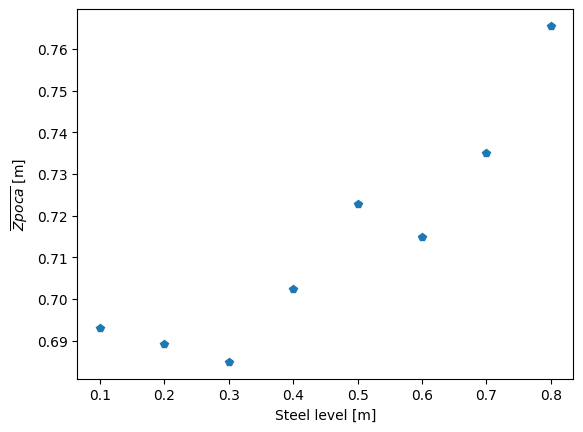

In [77]:
plt.plot(np.unique(TrueSteelLevels), LevelMeans, "p")
plt.xlabel("Steel level [m]")
plt.ylabel("$\overline{Zpoca}$ [m]")

Text(0, 0.5, '$\\overline{Zpoca}$ [m]')

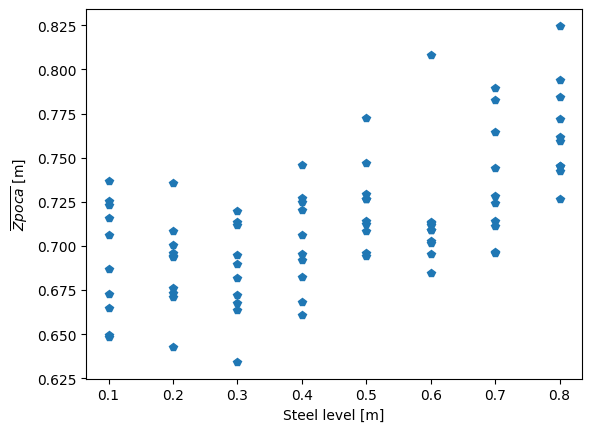

In [78]:
plt.plot(TrueSteelLevels, PocaZmeans, "p")
plt.xlabel("Steel level [m]")
plt.ylabel("$\overline{Zpoca}$ [m]")

(array([  1.,   1.,   3.,  18.,  62., 107., 720., 322.,  62.,  32.]),
 array([-6.46283865, -5.41670513, -4.37057114, -3.32443738, -2.27830362,
        -1.23216987, -0.18603611,  0.86009765,  1.9062314 ,  2.95236516,
         3.99849892]),
 <BarContainer object of 10 artists>)

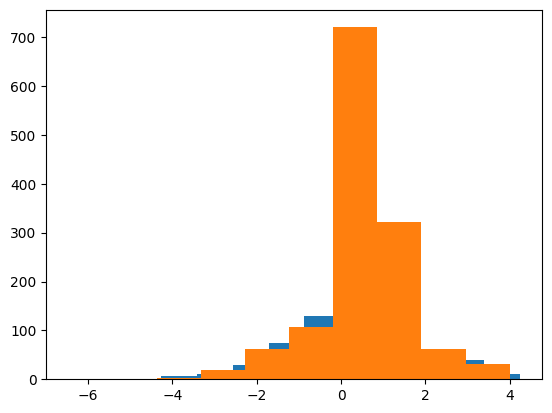

In [56]:
plt.hist(poca_x)
plt.hist(poca_y)


#### POCA within furnace XY walls

In [79]:
TrueSteelLevels = np.zeros(len(trn_passives.passives))
TrueSteelLevels[:] = np.nan

Poca_z_means = np.zeros(len(trn_passives.passives))
Poca_z_means[:] = np.nan

for i in range(0, len(trn_passives.passives)):
    # print(i)
    
    ProgBar(percent=100.0*i/len(trn_passives.passives))
    
    SelectedVolume = i
    f,t = trn_passives.passives[SelectedVolume]
    volume.load_rad_length(f, t)
    
    # plot_pred_true_x0(1/np.sqrt(volume.get_rad_cube()), 1/np.sqrt(volume.get_rad_cube()))
    
    GeneratedMuons = 1000
    muons = MuonBatch(gen(GeneratedMuons), init_z=1.8)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    volume(mu=muons)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    sb = ScatterBatch(mu=muons, volume=volume)
    sb.poca_xyz, sb.poca_xyz_unc

    Poca_z = sb.poca_xyz[:, 2].detach().numpy()

    # within XY furnace walls
    Poca_x = sb.poca_xyz[:, 0].detach().numpy()
    Poca_y = sb.poca_xyz[:, 1].detach().numpy()

    # Select POCA points within XY furnace walls
    f_x = (Poca_x > 0.1) & (Poca_x < 0.9)
    f_y = (Poca_y > 0.1) & (Poca_y < 0.9)
    f = f_x & f_y
    
    Poca_z = Poca_z[f]
    
    Poca_z_mean = np.mean(Poca_z)


    PassiveLayerThickness = 0.1
    SteelLevel_True = np.unique(volume.get_rad_cube()[:,4,4]==volume.get_rad_cube()[1,4,4], return_counts=True)[1][1]*PassiveLayerThickness
    SteelLevel_True

    
    TrueSteelLevels[i] = SteelLevel_True
    Poca_z_means[i] = Poca_z_mean

Completed: [============================= ]  98%

In [90]:
np.savetxt(("ladle_furnace_InferenceMethods/GeneratedData/TrueSteelLevels_WithinWalls.csv"), TrueSteelLevels)
np.savetxt(("ladle_furnace_InferenceMethods/GeneratedData/PocaZmeans_WithinWalls.csv"), PocaZmeans)

In [91]:
TrueSteelLevels = np.loadtxt("ladle_furnace_InferenceMethods/GeneratedData/TrueSteelLevels_WithinWalls.csv")
PocaZmeans = np.loadtxt("ladle_furnace_InferenceMethods/GeneratedData/PocaZmeans_WithinWalls.csv")

In [92]:
LevelMeans = np.array(np.unique(TrueSteelLevels))


for i in range(len(np.unique(TrueSteelLevels))):
    SteelLevel = np.unique(TrueSteelLevels)[i]
    LevelMeans[i] = np.mean(Poca_z_means[TrueSteelLevels==SteelLevel])

LevelMeans

array([0.67745299, 0.6890664 , 0.71870337, 0.75599994, 0.79019349,
       0.84342792, 0.89437065, 0.94080067])

Text(0, 0.5, '$\\overline{Zpoca}$ [m]')

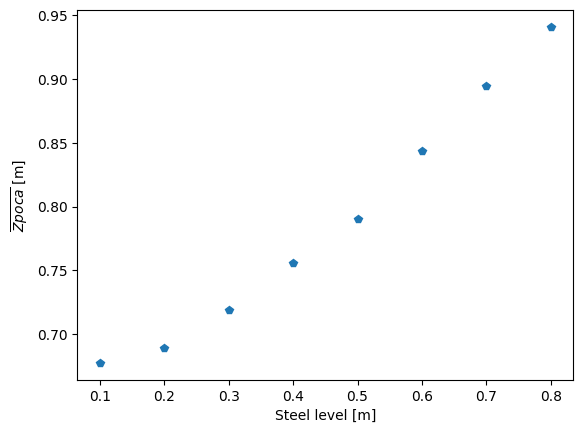

In [93]:
plt.plot(np.unique(TrueSteelLevels), LevelMeans, "p")
plt.xlabel("Steel level [m]")
plt.ylabel("$\overline{Zpoca}$ [m]")

(array([18., 25., 18., 12., 16., 16., 17., 10., 11., 16.]),
 array([0.10044067, 0.179221  , 0.25800136, 0.33678168, 0.415562  ,
        0.49434236, 0.57312268, 0.65190303, 0.73068339, 0.80946368,
        0.88824403]),
 <BarContainer object of 10 artists>)

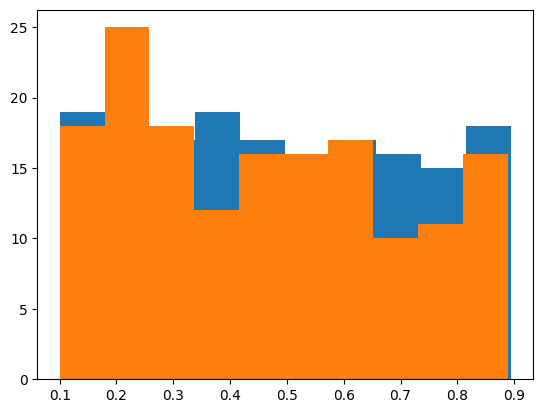

In [94]:
plt.hist(Poca_x[f])
plt.hist(Poca_y[f])

# Model steel level depending on Zpoca mean (1st, and 2nd order)

# Invert and get inference